In [1]:
import torch
from diffusers import DDPMPipeline, DDPMScheduler

In [2]:
from model import UNet2DConfig, UNet2DModel
cfg = UNet2DConfig()
cfg.sample_size = 96
cfg.down_block_types = ("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D")
cfg.up_block_types = ("AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D")
cfg.block_out_channels = (128, 256, 384, 512)
cfg.layers_per_block = 2
model = UNet2DModel(config=cfg).eval().cuda()
model.load_state_dict(torch.load('../weights/unet-2d.pth', map_location='cuda'))

<All keys matched successfully>

In [3]:
pipeline = DDPMPipeline(unet=model, scheduler=model.noise_scheduler)

In [4]:
from PIL import Image


def to_pil(x):
    x = (x/2 +.5).clamp(0,1)
    x = x.cpu().permute(0,2,3,1).numpy()
    x = (x * 255).round().astype("uint8")
    imgs = [Image.fromarray(i) for i in x]
    return imgs

In [5]:
import matplotlib.pyplot as plt

def plot_images_grid(images):
    num_images = len(images)
    grid_size = int(num_images ** 0.5) + (num_images % int(num_images ** 0.5) > 0)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    axes = axes.flatten()

    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')

    for ax in axes[num_images:]:
        ax.axis('off')

    plt.show()

In [6]:
import numpy as np
from tqdm import tqdm


def pipe(model, scheduler: DDPMScheduler, steps: int = 1000):
    image_size = (1, 3, cfg.sample_size, cfg.sample_size)
    image = torch.randn(image_size, device=model.device)
    scheduler.set_timesteps(steps)
    
    images = []
    for t in tqdm(torch.from_numpy(np.arange(0, steps)[::-1].copy())):
        y = model(image, t).sample.detach()
        image = scheduler.step(y, t, image).pred_original_sample
        if t%25==0:
            images.extend(to_pil(image))
    images.extend(to_pil(image))
    return images
    

In [7]:
out = pipe(model, model.noise_scheduler, 1000)

100%|██████████| 1000/1000 [01:35<00:00, 10.50it/s]


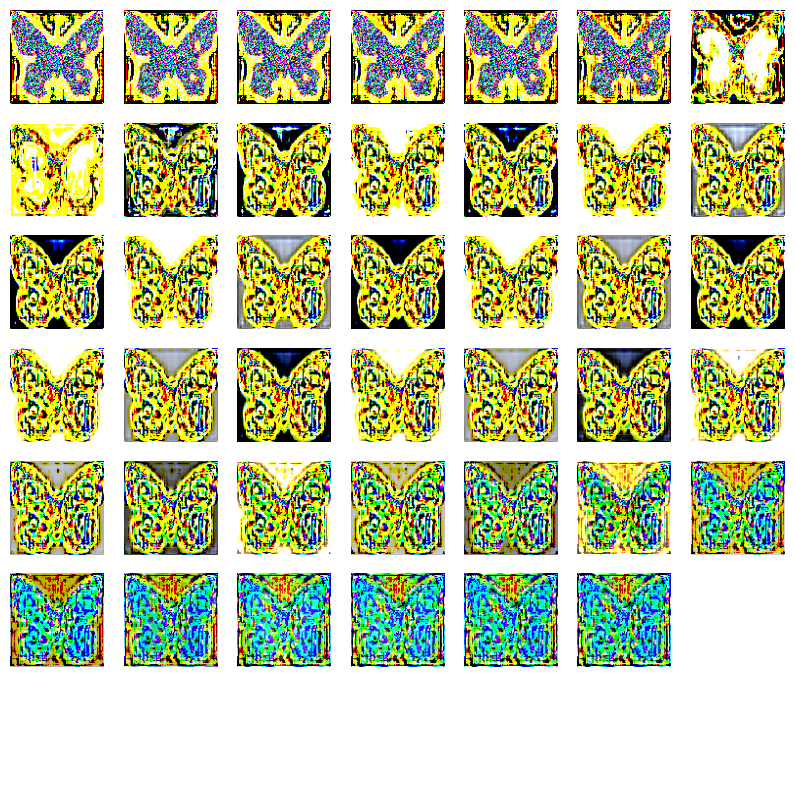

In [8]:
plot_images_grid(out)